In [24]:
%load_ext autoreload
%autoreload 2

In [2]:
%pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Using cached https://download.pytorch.org/whl/cu113/torch-1.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (1837.7 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchvision-0.13.1%2Bcu113-cp39-cp39-linux_x86_64.whl (23.4 MB)
  Using cached https://download.pytorch.org/whl/cu113/torchaudio-0.12.1%2Bcu113-cp39-cp39-linux_x86_64.whl (3.8 MB)
     |████████████████████████████████| 62 kB 2.3 MB/s  eta 0:00:01
  Using cached Pillow-9.5.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached numpy-1.25.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.7 MB)
     |████████████████████████████████| 199 kB 42.9 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 103.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 95.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 77 kB 7.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from data import get_data
from model import NetGN
from utils_train import train, test, infer
from utils_plot import imshow
import torch
import numpy as np
import torchvision


In [2]:
'''
Loading data without normalization
'''

train_ds = get_data(train=True, normalize=False)
test_ds = get_data(train=False, normalize=False)

Compose(
    ToTensor()
)
Files already downloaded and verified
Compose(
    ToTensor()
)
Files already downloaded and verified


In [3]:
'''
Feeding the data to dataloader to get tensors
'''



SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)


CUDA Available? True


In [4]:
'''
Getting statistics of the data to normalize accordingly
'''

dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(0.4870)
 - std R: tensor(0.2516)
 - var R: tensor(0.0633)
 - mean G: tensor(0.4835)
 - std G: tensor(0.2478)
 - var G: tensor(0.0614)
 - mean B: tensor(0.4535)
 - std B: tensor(0.2661)
 - var B: tensor(0.0708)


In [2]:
'''
Getting normalized data
'''

train_ds = get_data(train=True, normalize=True)
test_ds = get_data(train=False, normalize=True)
infer_ds = get_data(train=False, normalize=True)

Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified
Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.49, 0.45), std=(0.23, 0.23, 0.25))
)
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
infer_dataloader_args = dict(shuffle=False, batch_size=1, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_ds, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_ds, **dataloader_args)

# infer dataloader
infer_loader = torch.utils.data.DataLoader(infer_ds, **infer_dataloader_args)

CUDA Available? True


In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('[Train]')
print(' - Numpy Shape:', train_ds.data.shape)
print(' - Tensor Shape:', images.size())
print(' - min:', np.min(train_ds.data))
print(' - max:', np.max(train_ds.data))
print(' - mean R:', torch.mean(images[:, 0, :, :]))
print(' - std R:', torch.std(images[:, 0, :, :]))
print(' - var R:', torch.var(images[:, 0, :, :]))

print(' - mean G:', torch.mean(images[:, 1, :, :]))
print(' - std G:', torch.std(images[:, 1, :, :]))
print(' - var G:', torch.var(images[:, 1, :, :]))

print(' - mean B:', torch.mean(images[:, 2, :, :]))
print(' - std B:', torch.std(images[:, 2, :, :]))
print(' - var B:', torch.var(images[:, 2, :, :]))

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([128, 3, 32, 32])
 - min: 0
 - max: 255
 - mean R: tensor(-0.0567)
 - std R: tensor(1.0939)
 - var R: tensor(1.1967)
 - mean G: tensor(-0.0282)
 - std G: tensor(1.0774)
 - var G: tensor(1.1608)
 - mean B: tensor(0.0140)
 - std B: tensor(1.0643)
 - var B: tensor(1.1328)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


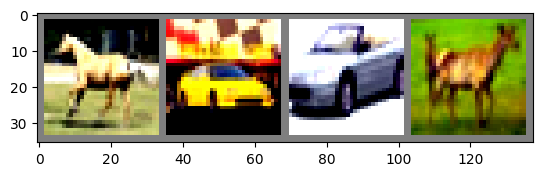

horse automobile automobile deer 


In [8]:
# get some random training images
batch_size=4
dataiter = iter(train_loader)
classes = train_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


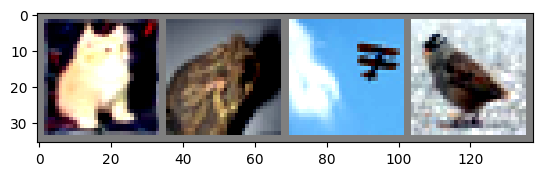

cat   frog  airplane bird 


In [9]:
# get some random testing images
batch_size=4
dataiter = iter(test_loader)
classes = test_ds.classes
images, labels = next(dataiter)
sampled_images = images[0: batch_size]
sampled_labels = labels[0: batch_size]

# show images
imshow(torchvision.utils.make_grid(sampled_images))
# print labels
print(' '.join(f'{classes[sampled_labels[j]]:5s}' for j in range(batch_size)))

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = NetGN().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5            [-1, 8, 32, 32]             576
              ReLU-6            [-1, 8, 32, 32]               0
         GroupNorm-7            [-1, 8, 32, 32]              16
           Dropout-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             128
        GroupNorm-10           [-1, 16, 32, 32]              32
        MaxPool2d-11           [-1, 16, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
        GroupNorm-14           [-1

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


In [11]:
from torch.optim.lr_scheduler import StepLR
model =  NetGN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_losses, train_acc)
    # scheduler.step()
    test(model, device, test_loader, test_losses, test_acc)
    # scheduler.step(test_acc[-1])

EPOCH: 0


Loss=1.5175281763076782 Batch_id=390 Accuracy=38.70: 100%|██████████| 391/391 [00:06<00:00, 58.35it/s]



Test set: Average loss: 1.4182, Accuracy: 4776/10000 (47.76%)

EPOCH: 1


Loss=1.2549903392791748 Batch_id=390 Accuracy=53.48: 100%|██████████| 391/391 [00:06<00:00, 62.90it/s]



Test set: Average loss: 1.1701, Accuracy: 5779/10000 (57.79%)

EPOCH: 2


Loss=1.0835189819335938 Batch_id=390 Accuracy=60.18: 100%|██████████| 391/391 [00:06<00:00, 62.92it/s]



Test set: Average loss: 1.0639, Accuracy: 6226/10000 (62.26%)

EPOCH: 3


Loss=0.8540837168693542 Batch_id=390 Accuracy=63.93: 100%|██████████| 391/391 [00:06<00:00, 62.44it/s]



Test set: Average loss: 1.0522, Accuracy: 6239/10000 (62.39%)

EPOCH: 4


Loss=0.8357924222946167 Batch_id=390 Accuracy=66.89: 100%|██████████| 391/391 [00:06<00:00, 60.29it/s]



Test set: Average loss: 0.9735, Accuracy: 6543/10000 (65.43%)

EPOCH: 5


Loss=0.8146170377731323 Batch_id=390 Accuracy=69.25: 100%|██████████| 391/391 [00:06<00:00, 63.36it/s]



Test set: Average loss: 0.8902, Accuracy: 6834/10000 (68.34%)

EPOCH: 6


Loss=0.7641001343727112 Batch_id=390 Accuracy=71.07: 100%|██████████| 391/391 [00:06<00:00, 62.78it/s]



Test set: Average loss: 0.8597, Accuracy: 6961/10000 (69.61%)

EPOCH: 7


Loss=0.9043236970901489 Batch_id=390 Accuracy=72.41: 100%|██████████| 391/391 [00:07<00:00, 54.49it/s]



Test set: Average loss: 0.8134, Accuracy: 7170/10000 (71.70%)

EPOCH: 8


Loss=0.6017597913742065 Batch_id=390 Accuracy=73.81: 100%|██████████| 391/391 [00:07<00:00, 54.96it/s]



Test set: Average loss: 0.7900, Accuracy: 7252/10000 (72.52%)

EPOCH: 9


Loss=0.8109487295150757 Batch_id=390 Accuracy=74.98: 100%|██████████| 391/391 [00:06<00:00, 63.86it/s]



Test set: Average loss: 0.7929, Accuracy: 7236/10000 (72.36%)

EPOCH: 10


Loss=0.8182299733161926 Batch_id=390 Accuracy=76.14: 100%|██████████| 391/391 [00:06<00:00, 62.25it/s]



Test set: Average loss: 0.7849, Accuracy: 7272/10000 (72.72%)

EPOCH: 11


Loss=0.5590630769729614 Batch_id=390 Accuracy=76.86: 100%|██████████| 391/391 [00:07<00:00, 54.69it/s]



Test set: Average loss: 0.7796, Accuracy: 7245/10000 (72.45%)

EPOCH: 12


Loss=0.549155056476593 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:06<00:00, 61.06it/s]  



Test set: Average loss: 0.7467, Accuracy: 7431/10000 (74.31%)

EPOCH: 13


Loss=0.5881908535957336 Batch_id=390 Accuracy=77.92: 100%|██████████| 391/391 [00:06<00:00, 60.61it/s] 



Test set: Average loss: 0.7272, Accuracy: 7480/10000 (74.80%)

EPOCH: 14


Loss=0.5728503465652466 Batch_id=390 Accuracy=78.17: 100%|██████████| 391/391 [00:07<00:00, 51.47it/s] 



Test set: Average loss: 0.7302, Accuracy: 7500/10000 (75.00%)

EPOCH: 15


Loss=0.5740549564361572 Batch_id=390 Accuracy=79.13: 100%|██████████| 391/391 [00:07<00:00, 55.58it/s] 



Test set: Average loss: 0.6942, Accuracy: 7644/10000 (76.44%)

EPOCH: 16


Loss=0.6694323420524597 Batch_id=390 Accuracy=79.25: 100%|██████████| 391/391 [00:07<00:00, 53.58it/s] 



Test set: Average loss: 0.6954, Accuracy: 7615/10000 (76.15%)

EPOCH: 17


Loss=0.5362192392349243 Batch_id=390 Accuracy=79.67: 100%|██████████| 391/391 [00:06<00:00, 63.48it/s] 



Test set: Average loss: 0.7164, Accuracy: 7532/10000 (75.32%)

EPOCH: 18


Loss=0.49287423491477966 Batch_id=390 Accuracy=80.33: 100%|██████████| 391/391 [00:06<00:00, 63.42it/s]



Test set: Average loss: 0.7083, Accuracy: 7615/10000 (76.15%)

EPOCH: 19


Loss=0.5080024003982544 Batch_id=390 Accuracy=80.70: 100%|██████████| 391/391 [00:06<00:00, 63.59it/s] 



Test set: Average loss: 0.7039, Accuracy: 7593/10000 (75.93%)



In [14]:
misclassified = []
infer(model, device, infer_loader, misclassified)


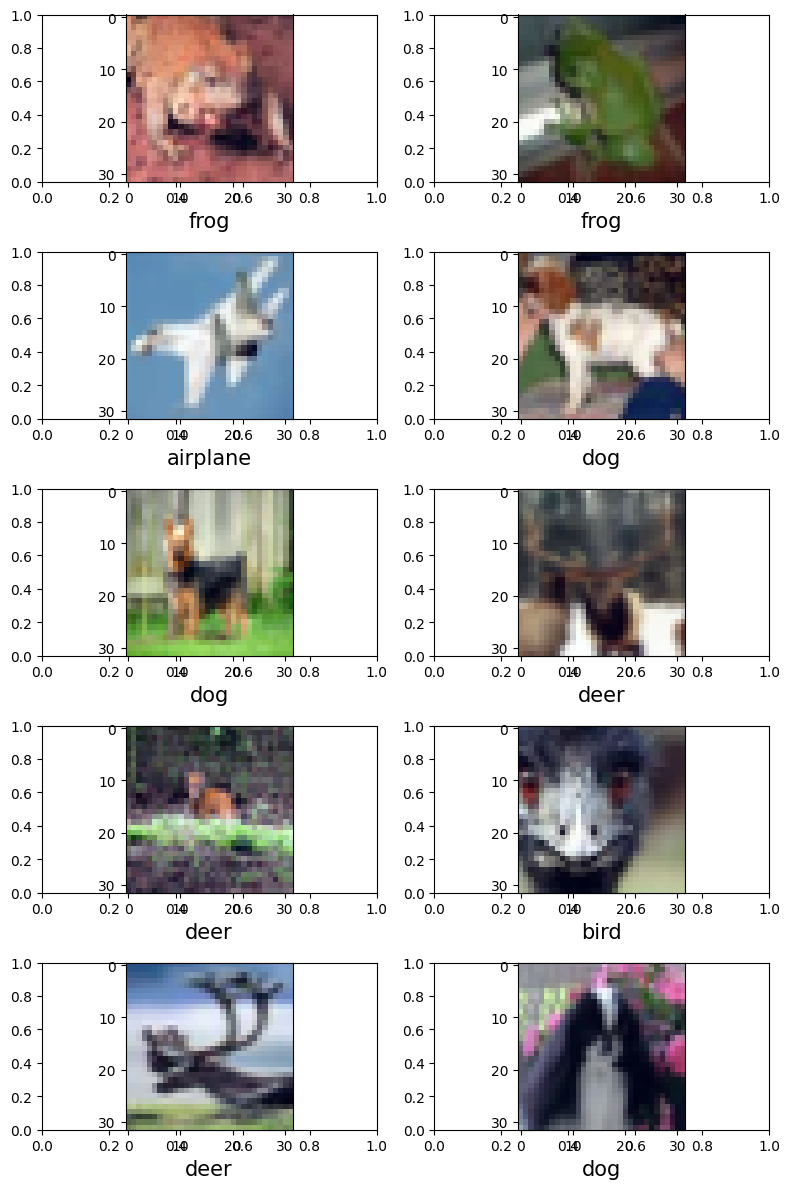

In [15]:
from utils_plot import plot_misclassified
plot_misclassified(infer_ds, misclassified)

Text(0.5, 1.0, 'Test Accuracy')

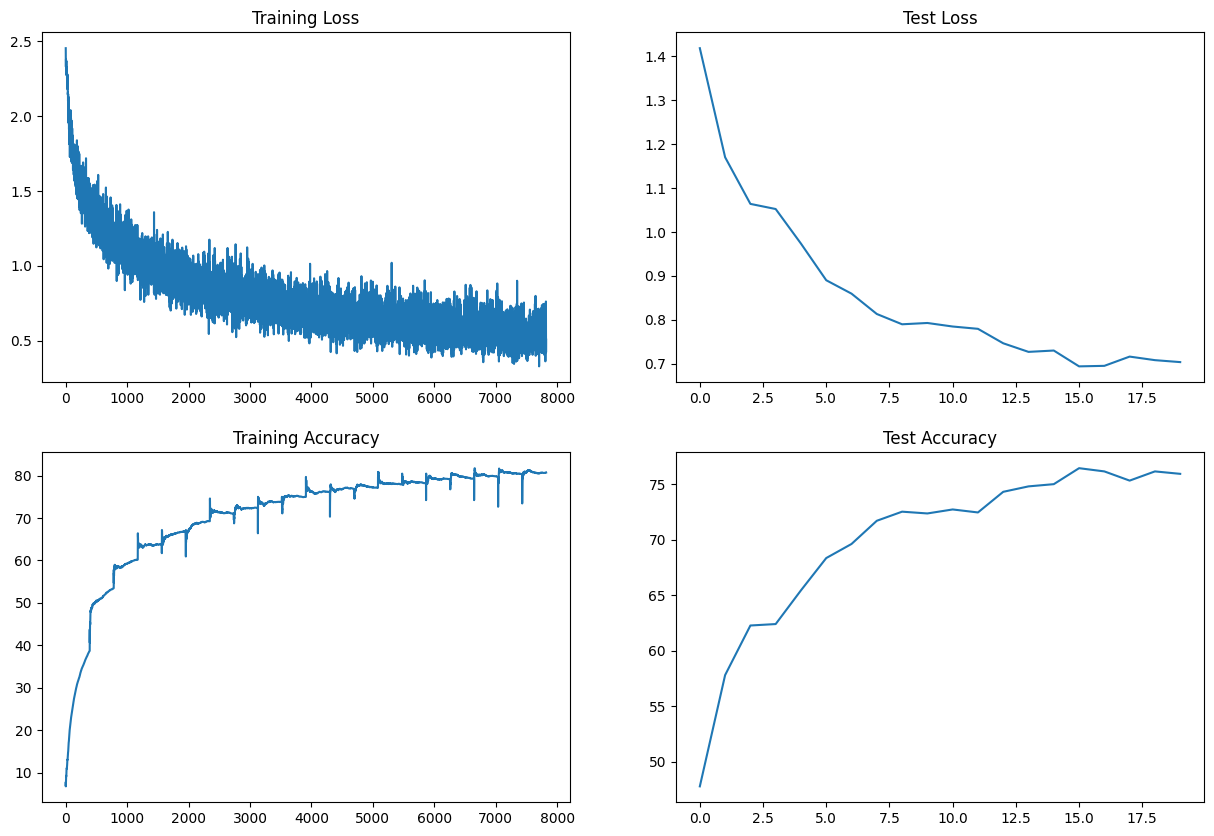

In [16]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")